<a href="https://colab.research.google.com/github/Sayggg/shapeai/blob/main/air_condition_controlling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [22]:
mkdir dataset_fa

In [ ]:
!unzip /content/drive/MyDrive/dataset_face.zip -d /content/dataset_fa

In [24]:
BASE_DIR = '/content/dataset_fa/UTKFace'

In [25]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [26]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/dataset_fa/UTKFace/26_0_3_20170119180...,26,0
1,/content/dataset_fa/UTKFace/26_1_2_20170116175...,26,1
2,/content/dataset_fa/UTKFace/35_1_0_20170117183...,35,1
3,/content/dataset_fa/UTKFace/20_1_0_20170116212...,20,1
4,/content/dataset_fa/UTKFace/40_0_0_20170117155...,40,0


mapping is done for the labels in the below cell

In [27]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

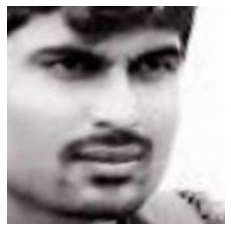

In [28]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

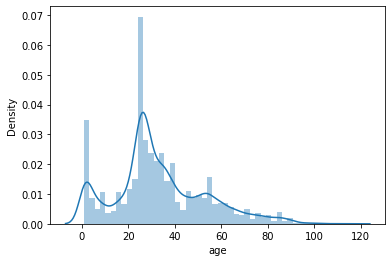

In [29]:
sns.distplot(df['age'])

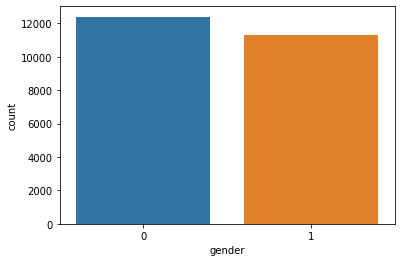

In [30]:
sns.countplot(df['gender'])

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Feature extraction

In [32]:

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [33]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [34]:
X.shape

(23708, 128, 128, 1)

In [35]:
# normalize the images
X = X/255.0

In [36]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [37]:
input_shape = (128, 128, 1)

model creation


In [38]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

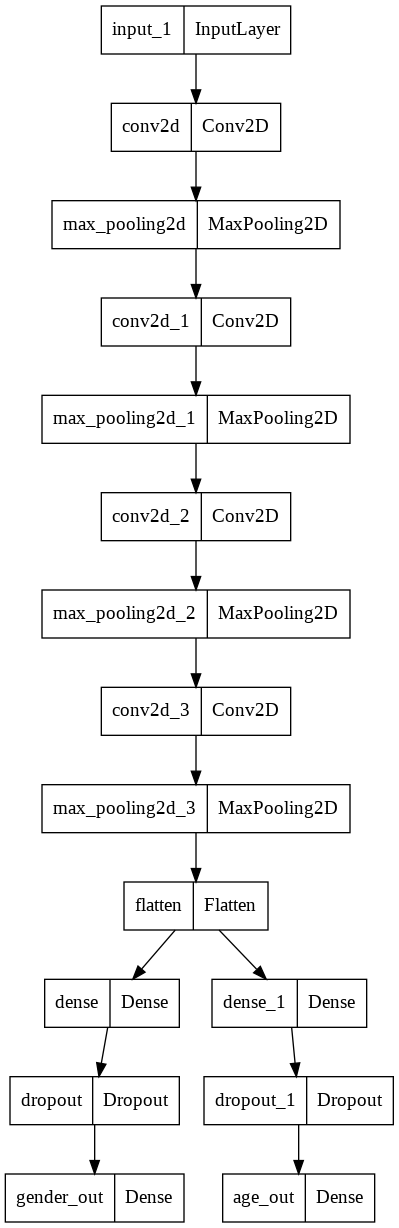

In [39]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [40]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
593/593 [==============================] - 643s 1s/step - loss: 16.1838 - gender_out_loss: 0.6961 - age_out_loss: 15.4877 - gender_out_accuracy: 0.5284 - age_out_accuracy: 0.0478 - val_loss: 13.3330 - val_gender_out_loss: 0.5902 - val_age_out_loss: 12.7428 - val_gender_out_accuracy: 0.6980 - val_age_out_accuracy: 0.0451
Epoch 2/3
593/593 [==============================] - 646s 1s/step - loss: 11.7992 - gender_out_loss: 0.5097 - age_out_loss: 11.2895 - gender_out_accuracy: 0.7523 - age_out_accuracy: 0.0370 - val_loss: 11.7243 - val_gender_out_loss: 0.4322 - val_age_out_loss: 11.2921 - val_gender_out_accuracy: 0.7980 - val_age_out_accuracy: 0.0238
Epoch 3/3
593/593 [==============================] - 647s 1s/step - loss: 10.2467 - gender_out_loss: 0.4264 - age_out_loss: 9.8203 - gender_out_accuracy: 0.8004 - age_out_accuracy: 0.0243 - val_loss: 9.1633 - val_gender_out_loss: 0.3791 - val_age_out_loss: 8.7842 - val_gender_out_accuracy: 0.8245 - val_age_out_accuracy: 0.0099


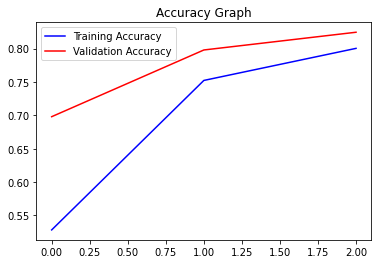

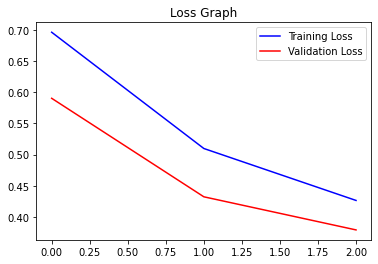

In [41]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

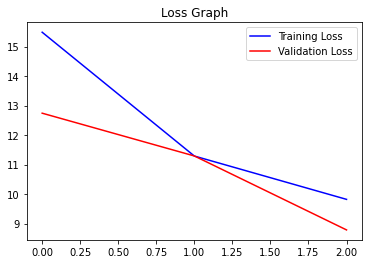

In [42]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Prediction with Test Data

In [43]:
count=0
print(count)
def prediction(image_index):
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  # predict from model
  pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
  count=count+1
  my_array = np.array([pred_gender, pred_age,count])
   
  return my_array
  
  

0


In [44]:
global count
count=0
print(count)

0


Original Gender: Male Original Age: 34
Predicted Gender: Male Predicted Age: 34


UnboundLocalError: ignored

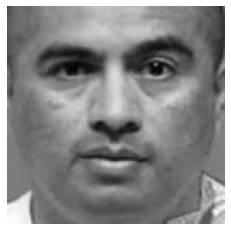

In [89]:
prediction(500)
print(prediction)

In [46]:
print(count)

0


We have to build it for both ,the employees of the office who work in the organizaton and also for the persons who come to visit the office and also the air condition should automatically decrease its load once a person leaves the office.This should be automatically done.


In [47]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


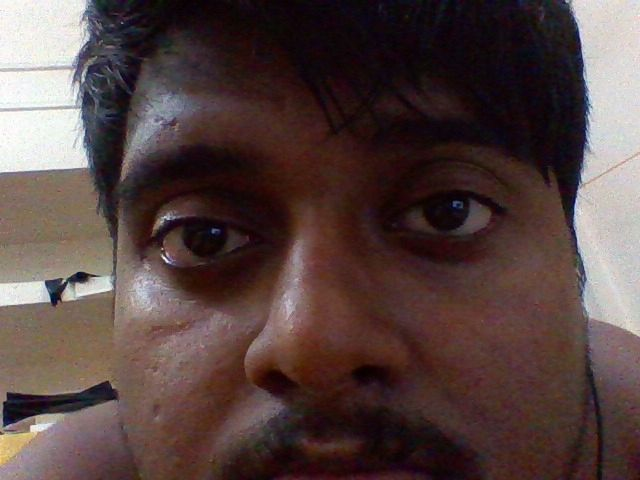

In [81]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [82]:
import cv2
cv2.imread('/content/photo.jpg')

array([[[248, 249, 247],
        [246, 247, 245],
        [245, 246, 244],
        ...,
        [222, 218, 213],
        [227, 223, 218],
        [231, 228, 223]],

       [[246, 247, 245],
        [244, 245, 243],
        [243, 244, 242],
        ...,
        [225, 221, 216],
        [226, 223, 218],
        [226, 226, 220]],

       [[243, 245, 245],
        [242, 244, 244],
        [241, 243, 243],
        ...,
        [230, 227, 223],
        [227, 226, 222],
        [225, 226, 222]],

       ...,

       [[160, 160, 174],
        [148, 148, 162],
        [139, 139, 153],
        ...,
        [ 21,  26,  57],
        [ 18,  23,  54],
        [ 14,  20,  49]],

       [[157, 157, 171],
        [148, 148, 162],
        [142, 142, 156],
        ...,
        [ 15,  20,  51],
        [ 10,  15,  46],
        [  5,  10,  41]],

       [[149, 149, 163],
        [146, 146, 160],
        [145, 145, 159],
        ...,
        [ 13,  18,  51],
        [  7,  12,  43],
        [  2,   7,  38]]

https://stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio

https://machinelearningmastery.com/how-to-load-convert-and-save-images-with-the-keras-api/

https://datascience.stackexchange.com/questions/112051/valueerror-cannot-reshape-array-of-size-36276416-into-shape-96-227-227-1

<class 'PIL.Image.Image'>
None
RGB
(640, 480)


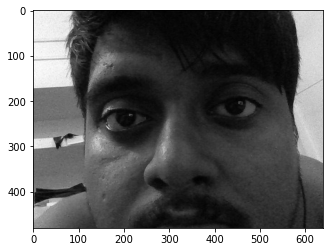

In [83]:
# example of saving an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
# load image as as grayscale
img = load_img('/content/photo.jpg', grayscale=True)
# convert image to a numpy array
img_array = img_to_array(img)
# save the image with a new filename
save_img('bondi_beach_grayscale.jpg', img_array)
# load the image to confirm it was saved correctly
img = load_img('bondi_beach_grayscale.jpg')
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

plt.imshow(img)

In [84]:
from PIL import Image

basewidth = 300
img = Image.open('/content/bondi_beach_grayscale.jpg')
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((128,128), Image.ANTIALIAS)
img.save('somepic.jpg')
features = []
img = np.array(img)
features.append(img)
print(img.shape)
features = np.array(features)
print(len(features))
features.shape
# ignore this step if using RGB
features = features.reshape(len(features), 128, 128, 1)

(128, 128)
1


In [85]:
global heat_duty
heat_duty=0

specific_heat_capacity=3.47#valid for all humans entering
print(heat_duty)

0


In [86]:
age=0
gender=0
count=0
print(age,gender,count)

0 0 0


In [87]:

def functionName(age,gender,count):
  global heat_duty
  count=count+1

  if gender == "male":
    if 20 > age and age > 11:  
      heat_duty=heat_duty+(4.5*specific_heat_capacity*11)
    if 30 > age and age > 20:
      heat_duty=heat_duty+(7.2*specific_heat_capacity*11)
    if 40 > age and age > 29:
      heat_duty=heat_duty+(7.05*specific_heat_capacity*11)

    if 50 > age and age > 39:  
      heat_duty=heat_duty+(6.63*specific_heat_capacity*11)
    if 60 > age and age > 49:
      heat_duty=heat_duty+(6.84*specific_heat_capacity*11)
    if 70 > age and age > 59:
      heat_duty=heat_duty+(6.8*specific_heat_capacity*11)
  else:
    if 20 > age and age > 11:  
      heat_duty=heat_duty+(3.5*specific_heat_capacity*11)
    if 30 > age and age > 20:
      heat_duty=heat_duty+(5.7*specific_heat_capacity*11)
    if 40 > age and age > 29:
      heat_duty=heat_duty+(5.52*specific_heat_capacity*11)
    if 50 > age and age > 39:  
      heat_duty=heat_duty+(5.98*specific_heat_capacity*11)
    if 60 > age and age > 49:
      heat_duty=heat_duty+(6.43*specific_heat_capacity*11)
    if 70 > age and age > 59:
      heat_duty=heat_duty+(5.82*specific_heat_capacity*11)
  return heat_duty



Original Gender: male Original Age: 21
Predicted Gender: Female Predicted Age: 2515


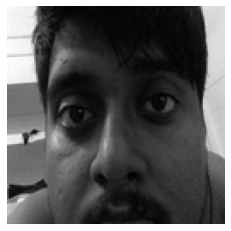

In [91]:
print("Original Gender:", "male", "Original Age:",21)
  # predict from model
pred = model.predict(features.reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(features.reshape(128, 128), cmap='gray');
count=count+1
my_array = np.array([pred_gender, pred_age,count])

let the outside temperature is 35 degree celcius and the temperature inside the office room is 24 degree celcius.So the difference in temperature(35-24=11)

In [78]:
functionName( pred_age,pred_gender,count)
#print(functionName(50,"male",count))


489.33940000000007
